# Data challenge Innovation

## DermaTrace: Multimodal Eczema Severity Estimation

Welcome to the DermaTrace project notebook. This notebook is the first step in building an AI-powered tool that estimates eczema severity from skin images, enriched with environmental context like humidity, pollen, and air quality.

In this notebook, I will:

- Load and preprocess eczema skin images from public datasets
- Train a baseline CNN (e.g., EfficientNet or ResNet) to classify severity (mild, moderate, severe)
- Visualize model attention using Grad-CAM
- Fetch environmental data (weather, pollen, air quality) using public APIs
- Align environmental data with image timestamps
- Lay the groundwork for integrating multimodal inputs in future iterations

This is the foundation for a transparent, explainable, and user-centric eczema tracking tool. Let’s get started!

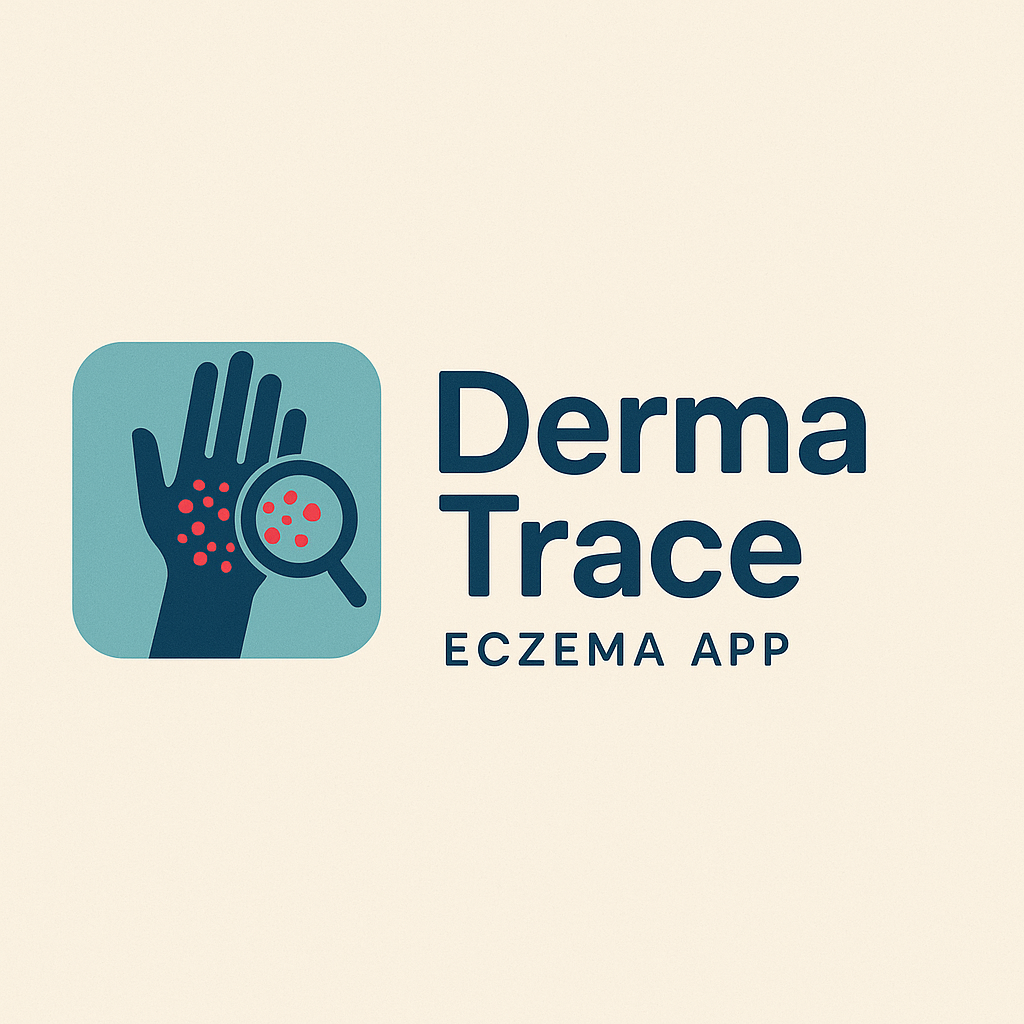

# 1. Imports and Setups

In this step, I'm importing all the libraries I’ll need for image preprocessing, model building, training, and visualization. I’m also setting up API access for environmental data.

In [1]:
# 1. Imports and Setup
import os
import glob
import numpy as np
import pandas as pd
import random
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import requests
import json

# 2. Load and Preprocess Image Data

Here I’m loading eczema skin images from a public dataset (like DermNetNZ) and my own labeled photos. I’ll use ImageDataGenerator to normalize the images and split them into training and validation sets. This prepares the data for the CNN and helps prevent overfitting.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the based directory of the testing folder
base_dir = "/content/drive/MyDrive/datasets/DermaTrace/test"

In [4]:
# Take a look inside the folder and how many photos/picture each folder content:
def count_images(path):
    exts = (".jpg", ".jpeg", ".png")
    return sum(1 for f in os.listdir(path) if f.lower().endswith(exts))

print("📁 Dataset structure:\n")

for folder in os.listdir(base_dir):
    full_path = os.path.join(base_dir, folder)
    if os.path.isdir(full_path):
        num_imgs = count_images(full_path)
        print(f"📂 {folder} — {num_imgs} images")

📁 Dataset structure:

📂 Bullous Disease Photos — 113 images
📂 Hair Loss Photos Alopecia and other Hair Diseases — 60 images
📂 Exanthems and Drug Eruptions — 101 images
📂 Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions — 288 images
📂 Acne and Rosacea Photos — 312 images
📂 Atopic Dermatitis Photos — 123 images
📂 Eczema Photos — 309 images
📂 Cellulitis Impetigo and other Bacterial Infections — 73 images
📂 Light Diseases and Disorders of Pigmentation — 143 images
📂 Herpes HPV and other STDs Photos — 102 images
📂 Lupus and other Connective Tissue diseases — 105 images
📂 Melanoma Skin Cancer Nevi and Moles — 116 images
📂 Nail Fungus and other Nail Disease — 261 images
📂 Poison Ivy Photos and other Contact Dermatitis — 65 images
📂 Psoriasis pictures Lichen Planus and related diseases — 352 images
📂 Systemic Disease — 152 images
📂 Urticaria Hives — 53 images
📂 Scabies Lyme Disease and other Infestations and Bites — 108 images
📂 Seborrheic Keratoses and other Benign Tumors — 

For this first version, we are only going to work with the test folder from the database of DermaNetz, later we are also going to train the model with a more train dataset scrapped from DermaNetz. After loading the structure of the test folder, I am going to chose the subfolders from Eczema/ Atopic Dermatitis Photos. That way the model will be trained only and exclusive with dermatitis data.

In [5]:
# Load ONLY the directory of eczema and atopuc Dermatatis Photos
ad_dir = os.path.join(base_dir, "Atopic Dermatitis Photos")
eczema_dir = os.path.join(base_dir, "Eczema Photos")

In [6]:
# Load all image files from the two folders (“Atopic Dermatitis” and “Eczema”) and store their file paths in two lists.
def load_images(folder):
    paths = glob.glob(os.path.join(folder, "**", "*.jpg"), recursive=True)
    paths += glob.glob(os.path.join(folder, "**", "*.jpeg"), recursive=True)
    paths += glob.glob(os.path.join(folder, "**", "*.png"), recursive=True)
    return paths

In [7]:
#Then print how many images were found in each folder:
ad_images = load_images(ad_dir)
eczema_images = load_images(eczema_dir)

print("Atopic Dermatitis:", len(ad_images))
print("Eczema:", len(eczema_images))

Atopic Dermatitis: 123
Eczema: 309


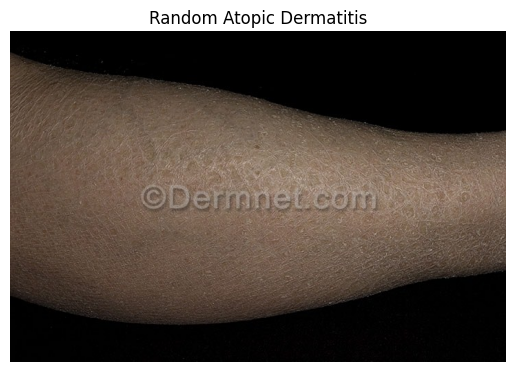

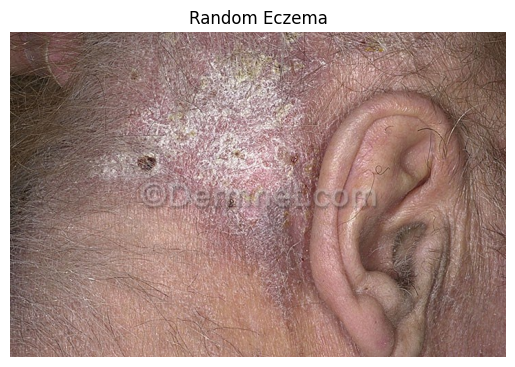

In [8]:
# Show random Atopic Dermatitis image
img = Image.open(random.choice(ad_images))
plt.imshow(img)
plt.title("Random Atopic Dermatitis")
plt.axis("off")
plt.show()

# Show random Eczema image
img = Image.open(random.choice(eczema_images))
plt.imshow(img)
plt.title("Random Eczema")
plt.axis("off")
plt.show()

In [9]:
# Preorocessing images of each dataset:
img_height, img_width = 224, 224

X = []   # images
y = []   # labels (0 = AD, 1 = eczema)

# --- Preprocess Atopic Dermatitis (label = 0) ---
print("Preprocessing Atopic Dermatitis images...")
for img_path in tqdm(ad_images):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((img_width, img_height))
    img = np.array(img) / 255.0        # normalize
    X.append(img)
    y.append(0)

# --- Preprocess Eczema (label = 1) ---
print("Preprocessing Eczema images...")
for img_path in tqdm(eczema_images):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((img_width, img_height))
    img = np.array(img) / 255.0        # normalize
    X.append(img)
    y.append(1)

X = np.array(X)
y = np.array(y)

print("\nPreprocessing complete!")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels:", np.unique(y))

Preprocessing Atopic Dermatitis images...


100%|██████████| 123/123 [00:03<00:00, 35.81it/s]


Preprocessing Eczema images...


100%|██████████| 309/309 [01:50<00:00,  2.79it/s]



Preprocessing complete!
X shape: (432, 224, 224, 3)
y shape: (432,)
Unique labels: [0 1]


# Data exploring classes (labels)
In this step I want to explore the classes of each image of the dataset. In that way, I can have labelled data before training and testing the model. This method will give me more precise results and then it could identify what part of the skin is being scanned.

In [10]:
# First, we want to know all the names labelled in the two folders: Eczema and Atopic Dermatitis samples.
import pandas as pd

df = pd.DataFrame({
    "filename": [os.path.basename(p) for p in ad_images + eczema_images],
    "label": ["Atopic Dermatitis"] * len(ad_images) + ["Eczema"] * len(eczema_images)
})

df

,filename,label
0,05atopic0123066.jpg,Atopic Dermatitis
1,05Atopic12060420.jpg,Atopic Dermatitis
2,05Atopic12060421.jpg,Atopic Dermatitis
3,05AtopicChild020120.jpg,Atopic Dermatitis
4,05Atopic12060411.jpg,Atopic Dermatitis
...,...,...
427,stasis-dermatitis-146.jpg,Eczema
428,stasis-dermatitis-97.jpg,Eczema
429,stasis-dermatitis-92.jpg,Eczema
430,stasis-dermatitis-93.jpg,Eczema


Based on what we can see in the photos names, we are going to correct the labels by extracting the body_part & diagnosis from the filenames. That way we can have a specific name for each picture.

In [11]:
# In this step I am going to extract the body part and diagnosis from filenames adding new columns: body_part and diagnosis_guess based on the name:
def parse_from_name(name):
    n = name.lower()

    # --- body part ---
    if "face" in n or "lids" in n or "eyelid" in n or "cheek" in n:
        body_part = "face"
    elif "hand" in n or "finger" in n or "palm" in n:
        body_part = "hand"
    elif "arm" in n or "forearm" in n:
        body_part = "arm"
    elif "leg" in n or "thigh" in n:
        body_part = "leg"
    elif "foot" in n or "feet" in n or "toe" in n:
        body_part = "foot"
    elif "trunk" in n or "chest" in n or "back" in n:
        body_part = "trunk"
    else:
        body_part = "unknown"

    # --- diagnosis / subtype ---
    if "atopic" in n or "eczema" in n or "dermatitis" in n:
        diagnosis = "atopic_eczema"
    elif "pityriasis" in n:
        diagnosis = "pityriasis_alba"
    elif "keratosis" in n:
        diagnosis = "keratosis_pilaris"
    elif "ichthyosis" in n:
        diagnosis = "ichthyosis"
    elif "dyshidrosis" in n:
        diagnosis = "dyshidrosis"
    else:
        diagnosis = "other_or_unknown"

    # --- high-level eczema / non-eczema label ---
    # treat all eczema-like conditions as eczema = 1
    if diagnosis in ["atopic_eczema", "pityriasis_alba", "dyshidrosis"]:
        eczema_binary = 1   # eczema
    elif diagnosis in ["keratosis_pilaris", "ichthyosis"]:
        eczema_binary = 0   # clearly non-eczema
    else:
        eczema_binary = None  # unknown / maybe drop later

    return body_part, diagnosis, eczema_binary

In [12]:
df[["body_part", "diagnosis_guess", "eczema_binary"]] = df["filename"].apply(
    lambda x: pd.Series(parse_from_name(x))
)

In [13]:
df_clean = df[df["eczema_binary"].notna()]

In [14]:
df_clean

,filename,label,body_part,diagnosis_guess,eczema_binary
0,05atopic0123066.jpg,Atopic Dermatitis,unknown,atopic_eczema,1.0
1,05Atopic12060420.jpg,Atopic Dermatitis,unknown,atopic_eczema,1.0
2,05Atopic12060421.jpg,Atopic Dermatitis,unknown,atopic_eczema,1.0
3,05AtopicChild020120.jpg,Atopic Dermatitis,unknown,atopic_eczema,1.0
4,05Atopic12060411.jpg,Atopic Dermatitis,unknown,atopic_eczema,1.0
...,...,...,...,...,...
427,stasis-dermatitis-146.jpg,Eczema,unknown,atopic_eczema,1.0
428,stasis-dermatitis-97.jpg,Eczema,unknown,atopic_eczema,1.0
429,stasis-dermatitis-92.jpg,Eczema,unknown,atopic_eczema,1.0
430,stasis-dermatitis-93.jpg,Eczema,unknown,atopic_eczema,1.0


In [15]:
df_clean["body_part"].value_counts()
df_clean["diagnosis_guess"].value_counts()

,count
diagnosis_guess,
atopic_eczema,250
dyshidrosis,10
keratosis_pilaris,7
ichthyosis,5
pityriasis_alba,3


Based on this structuring of the data I can see that there's some images that are not classified as eczema for example: ichthyosis, keratosis pilaris, pityriasis alba. Those are labels that exists in the folders but they are NOT eczema. So we are going to cleaning the dataset while just having eczema and atopic dermatitis photos in the dataset.

# 3. Choosing the Backbone Models for Eczema Detection

After the preprocessing of the images, I will use several ImageNet CNN backbones as feature extractors and then adds its own severity heads. The three models that I'm going to use in this first test version is ResNet50, InceptionV3 and DenseNet121.

- **ResNet50** is a widely used deep CNN architecture known for its stability and strong performance on many medical imaging tasks.
It uses residual connections, which help the model avoid vanishing gradients and learn more complex features.
ResNet50 is a strong baseline model for almost any classification task, making it a good starting point for eczema detection.

- **InceptionV3** uses a multi-scale convolutional design that extracts features at different sizes simultaneously. This is useful for eczema because lesions appear:  in various sizes (from small spots to large patches), on different body parts and with different shapes and borders.
The architecture captures fine details and global patterns, which makes it suitable for dermatology images.

- **DenseNet121** connects every layer to every other layer, promoting feature reuse and improving gradient flow. This makes DenseNet especially good at learning subtle visual differences—important for eczema, where redness, dryness, and scaling textures are key cues.

In [16]:
# first: train+val vs test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# now: train vs val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (276, 224, 224, 3) (276,)
Val:   (69, 224, 224, 3) (69,)
Test:  (87, 224, 224, 3) (87,)


In [17]:
# 3. Build Baseline CNN Model (ResNet50)
IMG_SIZE = (224, 224, 3)
NUM_CLASSES = 2  # eczema vs non-eczema

def build_model(base_name="resnet50"):
    if base_name == "resnet50":
        Base = tf.keras.applications.ResNet50
    elif base_name == "inceptionv3":
        Base = tf.keras.applications.InceptionV3
    elif base_name == "densenet121":
        Base = tf.keras.applications.DenseNet121
    else:
        raise ValueError("Unknown base model")

    base_model = Base(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SIZE,
        pooling="avg"
    )
    base_model.trainable = False  # first train head only

    inputs = layers.Input(shape=IMG_SIZE)
    x = base_model(inputs, training=False)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [18]:
for backbone in ["resnet50", "inceptionv3", "densenet121"]:
    print("\n=== Training", backbone, "===")
    model = build_model(backbone)
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32
    )


=== Training resnet50 ===
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 88s 9s/step - accuracy: 0.6758 - loss: 0.6739 - val_accuracy: 0.7101 - val_loss: 0.6613
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 71s 8s/step - accuracy: 0.6877 - loss: 0.6880 - val_accuracy: 0.7101 - val_loss: 0.6040
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 78s 9s/step - accuracy: 0.6597 - loss: 0.6626 - val_accuracy: 0.7101 - val_loss: 0.6119
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - accuracy: 0.6729 - loss: 0.7034 - val_accuracy: 0.7101 - val_loss: 0.6158
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 9s/step - accuracy: 0.7085 - loss: 0.6241 - val_accuracy: 0.7101 - val_loss: 0.5999
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 85s 10s/step - accuracy: 0.7109 - loss: 0.6105 - val_accuracy: 0.7101 - val_loss: 0.6006
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 78s 9s/step - accuracy: 0.7638 - loss: 0.5605 - val_accuracy: 0.7101 - val_loss: 0.6001
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - acc

This is the end of the first part: The rest is a pipeline.

In [19]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

IndexError: list index out of range

# 4. Train model

In this step, I’m training the CNN on my preprocessed images. I’ll monitor validation accuracy and use early stopping to avoid overfitting. My goal is to reach at least 75% accuracy and get a feel for how well the model can distinguish between severity levels.


In [ ]:
# 4. Train Model
callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

# 5. Grad-CAM Visualization (for explainability)

Once the model is trained, I’ll use Grad-CAM to visualize which parts of the image influenced the prediction. This helps me check if the model is focusing on the actual eczema lesions and not irrelevant areas. It’s also a key part of making the system explainable for users.


In [ ]:
# 5. Grad-CAM Visualization (for explainability)
# Placeholder for Grad-CAM function
def generate_gradcam(model, img_array, class_index):
    # Grad-CAM logic here
    pass

# Example usage:
# gradcam = generate_gradcam(model, sample_image, predicted_class)
# plt.imshow(gradcam)

# 6. Fetch Environmental Data (KNMI, Open-Meteo, Luchtmeetnet)

Here I’m writing functions to fetch environmental data (humidity, pollen, air quality) using public APIs like KNMI and Open-Meteo. I’ll test these calls with sample dates and locations to make sure I can retrieve relevant data that might affect eczema flare-ups

In [ ]:
# Example: Fetch humidity and temperature from KNMI
def fetch_knmi_weather(date, location):
    # Replace with actual API call and parsing logic
    return {"temperature": 18.5, "humidity": 72}

# Example usage:
# weather_data = fetch_knmi_weather("2025-11-05", "Tilburg")


# 7. Align Environmental Data with Image Metadata

In this step, I’ll match environmental data to each image based on its timestamp and location. This will let me later combine visual and environmental features in a multimodal model. For now, I’m just making sure the data alignment works properly.

In [ ]:
# 7. Align Environmental Data with Image Metadata
# Placeholder for merging image timestamps with environmental context
def align_environmental_data(image_metadata_df, env_data_df):
    # Merge logic here
    return pd.merge(image_metadata_df, env_data_df, on="timestamp")

# 8. Save Outputs and Prepare for Streamlit Demo

Finally, I’m saving the trained model and Grad-CAM outputs so I can use them in a Streamlit demo. The demo will let users upload a photo, get a severity score, see a heatmap, and view environmental factors. This wraps up the first phase of the project

In [ ]:
model.save("models/eczema_severity_model.h5")
# Save Grad-CAMs, predictions, and environmental features for demo
